In [13]:
import datacube
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import folium
import datacube.storage.masking as masking

# importing dask stuff
import dask
from dask.distributed import Client, progress

# importing notebook utils, so we can focus on the good stuff
import dask_notebook_utils

# setting up the connections
print('dask version: {0}\ndatacube version: {1}'.format(dask.__version__, datacube.__version__))
client = Client('dask-datacube-dask.default.svc.cluster.local:8786') #Client() to initialize a LocalCluster
client

dask version: 1.1.1
datacube version: 1.6.2+353.gac2866b5.dirty


Client Scheduler: tcp://dask-datacube-dask.default.svc.cluster.local:8786 Dashboard: http://dask-datacube-dask.default.svc.cluster.local:8787/status,Cluster Workers: 6 Cores: 12 Memory: 36.00 GB


# A bit of background on Dask

Dask does not execute your functions when you call them.
Instead it delayes them to be able to build an efficient **execution graph** (a recipe) for your workflow, and execute it when you explicitly say so

To enable this you need to wrap your function using **dask.delayed**

In [2]:
@dask.delayed
def complex_sum(a, b):
    return a+b

In [3]:
very_complex_sum = dask.delayed(sum)

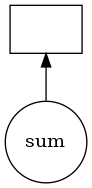

In [4]:
a = np.arange(10)
result = very_complex_sum(a, a)

# Here is the recipe
dask.visualize(result)

However this is still not enough for dask to work at its best. In fact dask still cannot parallelized the job, unless you tell how you want to distribute it.

This is achieved by using **chunks**, a *super-element* of your data that groups many of your *elements* in your input data.
This is supported by using dask data formats, and many common libraries like pandas and xarray already support it

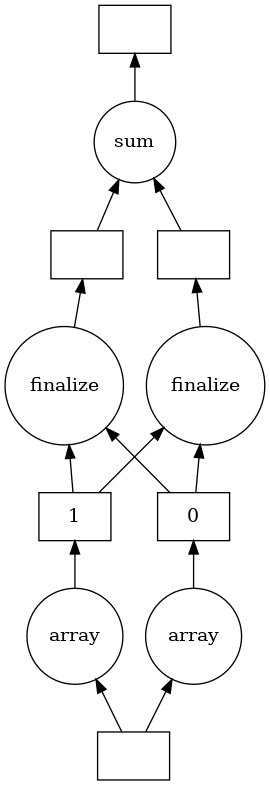

In [5]:
d = dask.array.from_array(a, chunks=(5))
result = very_complex_sum(d, d)

# This now should look better
dask.visualize(result)

To fully leverage dask, please have a look at the following functions:
* blocking execution [dask.compute](http://docs.dask.org/en/latest/api.html#dask.compute)
* non-blocking execution [dask.persist](http://docs.dask.org/en/latest/api.html#dask.persist)
  make sure to `del` your variable if you don't use it anymore
* [client.gather](http://docs.dask.org/en/latest/futures.html?highlight=client%20gather#distributed.Client.gather) and [Future.result](http://docs.dask.org/en/latest/futures.html?highlight=client%20gather#distributed.Future.result)

Also, have a look at the *Dask Diagnostic* page, including:
* [local progress bar](http://docs.dask.org/en/latest/diagnostics-local.html)
* [distributed progress bar](http://docs.dask.org/en/latest/diagnostics-distributed.html#progress-bar)
* [dask dashboard](http://docs.dask.org/en/latest/diagnostics-distributed.html#dashboard)

# Loading the data

In [6]:
dc = datacube.Datacube(app='dc-visualize')

In [7]:
m, x, y = dask_notebook_utils.visualize_target_area(top_left=(-9.222301, 111.685344), bottom_right=(-44.715895, 155.223454))
m

In [8]:
%%time
date_range = (
    datetime.datetime(2017, 1, 1),
    datetime.datetime(2018, 12, 31)
)

ds = dc.load(
    product='ls8_nbart_geomedian_annual',
    x=x, y=y,
    output_crs='epsg:3577',
    resolution=(-30, 30),
    time = date_range,
    dask_chunks = {'x': 8000, 'y': 8000, 'time': 1},
    measurements = {'red', 'green', 'blue', 'nir'}
)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 1, x: 163768, y: 136423)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01
  * y        (y) float64 -9.648e+05 -9.648e+05 ... -5.057e+06 -5.057e+06
  * x        (x) float64 -2.294e+06 -2.294e+06 ... 2.619e+06 2.619e+06
Data variables:
    nir      (time, y, x) int16 dask.array<shape=(1, 136423, 163768), chunksize=(1, 8000, 8000)>
    blue     (time, y, x) int16 dask.array<shape=(1, 136423, 163768), chunksize=(1, 8000, 8000)>
    red      (time, y, x) int16 dask.array<shape=(1, 136423, 163768), chunksize=(1, 8000, 8000)>
    green    (time, y, x) int16 dask.array<shape=(1, 136423, 163768), chunksize=(1, 8000, 8000)>
Attributes:
    crs:      epsg:3577
CPU times: user 1min 39s, sys: 1.63 s, total: 1min 40s
Wall time: 1min 38s


# Calculating a downsampled version of Australia (30km pixel size)

In [11]:
%%time
data = ds[['red', 'green', 'blue']].isel(time=0)
little_Australia = dask_notebook_utils.downsample_by_chunks(data, rechunking=(1000, 1000, 1))

CPU times: user 912 ms, sys: 4 ms, total: 916 ms
Wall time: 926 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


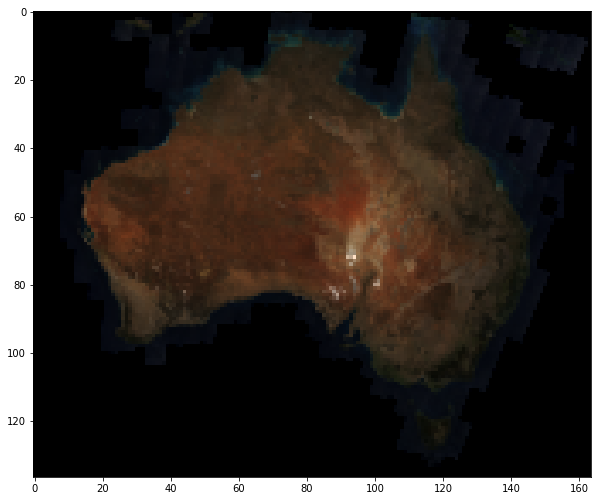

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(little_Australia/np.nanmax(little_Australia))

# The color of Australia!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


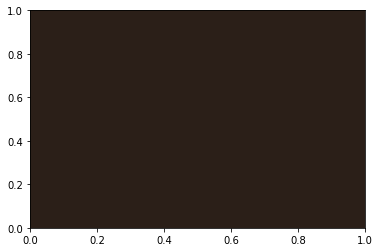

In [8]:
pixel = np.nanmean(np.nanmean(np.where(little_Australia > 0, little_Australia, np.nan), axis=0), axis=0)

hex_colour = '#{:02x}{:02x}{:02x}'.format(
    int(pixel[0]*255),
    int(pixel[1]*255),
    int(pixel[2]*255)
)
from matplotlib.patches import Rectangle
someX, someY = 0.5, 0.5
fig,ax = plt.subplots()
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - 0.5, someY - 0.5), 1.0, 1.0,
                      alpha=1, facecolor=hex_colour))

# Map + Reduce Exercise. 
## Calculating 5 years of NDVI, then take the average over time

If your workflow results in a data aggregation (mean over time for example) then dask is what you are after.

Thanks to the integration with datacube/xarray, chunks in space and time are possible.
This will be leveraged by dask, and prioritize the data aggregation over other tasks.

In the case of mean over time, this means that dask will prioritize the execution on chunks having same space attributes but different time, so that it can perform the reduction (less memory!) before moving to other areas.

Beware, this is more of a general optimization of the execution graph. If workers are waiting for other data to perform the aggregation, they will keep computing other areas

In [3]:
m, x, y = dask_notebook_utils.visualize_target_area(top_left=(-40.7, 144.5), bottom_right=(-43.7, 148.7))
m

In [4]:
%%time
date_range = (
    datetime.datetime(2013, 1, 1),
    datetime.datetime(2018, 12, 31)
)

ds_tasmania = dc.load(
    product='ls8_nbart_geomedian_annual',
    x=x,
    y=y,
    output_crs='epsg:3577',
    resolution=(-30, 30),
    time = date_range,
    dask_chunks = {'x': 1000, 'y': 1000, 'time': 1},
    measurements = {'red', 'nir'}
)
print(ds_tasmania)

<xarray.Dataset>
Dimensions:  (time: 5, x: 13034, y: 12095)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2014-01-01 ... 2017-01-01
  * y        (y) float64 -4.503e+06 -4.503e+06 ... -4.866e+06 -4.866e+06
  * x        (x) float64 1.043e+06 1.043e+06 1.043e+06 ... 1.434e+06 1.434e+06
Data variables:
    red      (time, y, x) int16 dask.array<shape=(5, 12095, 13034), chunksize=(1, 1000, 1000)>
    nir      (time, y, x) int16 dask.array<shape=(5, 12095, 13034), chunksize=(1, 1000, 1000)>
Attributes:
    crs:      epsg:3577
CPU times: user 2.26 s, sys: 0 ns, total: 2.26 s
Wall time: 2.3 s


In [ ]:
%%time
mask = ds_tasmania.nir >= 0
ds_tasmania = ds_tasmania.where(mask)
ndvi_data = dask_notebook_utils.ndvi(ds_tasmania.nir, ds_tasmania.red).mean(dim='time')
ndvi_data_res = dask_notebook_utils.downsample_by_chunks(ndvi_data, rechunking=(100, 100))

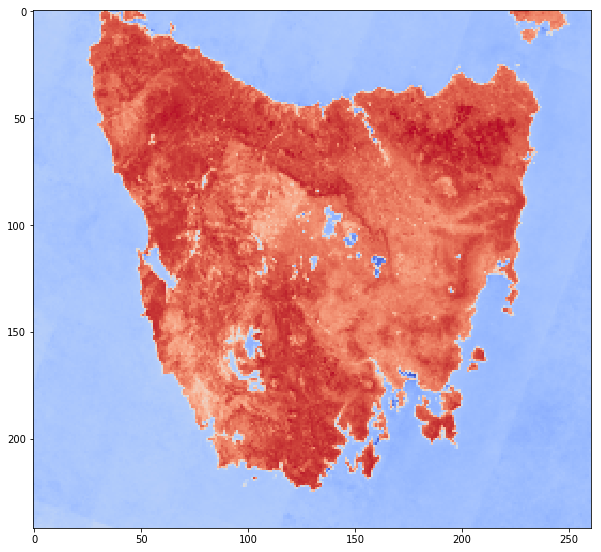

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ndvi_data_res/np.nanmax(ndvi_data_res), cmap='coolwarm')